**SOLAR WIND HANDS-ON NOTEBOOK**

Our goal is to numerically integrate Parker (1958) type critical-point equations (with a number of physics bells and whistles added) to solve for the radial dependence of the solar wind speed.

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

Define a function to integrate the critical-point equations for one choice of temperature parameters:

In [150]:
def wind_radial_onefluid(nr,rxmax,mu,Tmax,psi,delta):
    xRsun = 6.96e10
    boltzk = 1.380622e-16
    xmHyd = 1.677333e-24
    Gconst = 6.6732e-8
    xMsun = 1.989e33
    
    # set up radial arrays ("rx" is in units of solar radii)
    
    rx = 10.**(np.linspace(np.log10(1.000001),np.log10(rxmax),num=nr))
    rcm = rx * xRsun
    drcm_mid = np.gradient(rcm)
    
    # use the Cranmer & Schiff (2016) parameters to set up a T(r) function
    
    xstar = (psi-2.)**(1./(psi-3.))
    zeta0 = (xstar**(psi-2.))/(psi-3.)
    T = Tmax * (zeta0*(1./rx - rx**(2.-psi)))**delta
    
    # now that we know T(r), set up the sound speed and right-hand side of the Parker equation of motion

    a2 = boltzk*T/mu/xmHyd
    da2dr = np.gradient(a2)/drcm_mid
    RHS = -da2dr + 2.*a2/rcm - Gconst*xMsun/rcm/rcm
    dRHSdr = np.gradient(RHS)/drcm_mid
    
    # integrate the RHS to obtain the Kopp & Holzer (1976) quantity that is minimized at the critical point
    
    RHSINT = np.cumsum(RHS*drcm_mid)
    ircrit = np.argmin(RHSINT)
    interp = interpolate.interp1d(RHS[ircrit-5:ircrit+5],rx[ircrit-5:ircrit+5],kind="linear")
    rxcrit = interp(0.)
    
    # at the critical point, interpolate to find quantities needed for L'Hopital's rule
    
    interp = interpolate.interp1d(rx,a2,kind="linear")
    a2crit = interp(rxcrit)
    interp = interpolate.interp1d(rx,da2dr,kind="linear")
    da2dr_crit = interp(rxcrit)
    interp = interpolate.interp1d(rx,dRHSdr,kind="linear")
    dRHSdr_crit = interp(rxcrit)
    
    # apply L'Hopital's rule to find the slope du/dr at the critical point
     
    ucrit = np.sqrt(a2crit)
    ducdr = da2dr_crit/2./ucrit
    dudr_crit = 0.5*(ducdr + np.sqrt(ducdr**2 + 2.*dRHSdr_crit))
    
    # find the array indices that surround the critical point
    
    indr = np.linspace(0,nr-1,num=nr,dtype=int)
    indcritLO = np.max(indr.compress((rx < rxcrit).flat))
    indcritHI = indcritLO + 1
    drLO = xRsun * (rxcrit - rx[indcritLO])
    drHI = xRsun * (rx[indcritHI] - rxcrit)
    
    # set up the wind speed array u(r), and get ready to integrate up and down from critical point
    
    u = np.zeros(nr)
    u[indcritLO] = ucrit - drLO*dudr_crit
    u[indcritHI] = ucrit + drHI*dudr_crit
    
    # integrate up!
    
    for i in range(indcritHI,nr,1):
        drcm = rcm[i]-rcm[i-1]
        DDD = u[i-1] - a2[i-1]/u[i-1]
        u[i] = u[i-1] + drcm*RHS[i-1]/DDD
    
    # integrate down!
    
    for i in range(indcritLO,-1,-1):
        drcm = rcm[i+1]-rcm[i]
        DDD = u[i+1] - a2[i+1]/u[i+1]
        u[i] = u[i+1] - drcm*RHS[i+1]/DDD

    return rxcrit,rx,T,u,ucrit

Our FIRST TEST will just run the function once, for representative values, and see what we get...

 Wind speed at 1 AU:  459.8572233748986  km/s


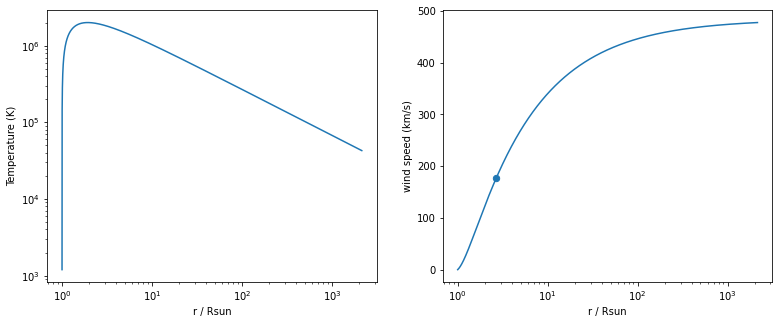

In [168]:
nr = 90000
rxmax = 2150.   # that's 10 AU
mu = 0.5
Tmax = 2.0e6
psi = 4.2
delta = 0.6

rxcrit,rx,T,u,ucrit = wind_radial_onefluid(nr,rxmax,mu,Tmax,psi,delta)

interp = interpolate.interp1d(rx,u,kind="linear")
u1au = interp(215.)/1.e5
print(" Wind speed at 1 AU: ",u1au," km/s")

plt.figure(figsize=[13,5])
plt.subplot(121)
plt.xscale("log")
plt.yscale("log")
plt.plot(rx,T)
plt.xlabel('r / Rsun')
plt.ylabel('Temperature (K)')
plt.subplot(122)
plt.xscale("log")
#plt.yscale("log")
plt.plot(rx,u/1.e5)
plt.scatter(rxcrit,ucrit/1.e5,s=40)
plt.xlabel('r / Rsun')
plt.ylabel('wind speed (km/s)');

Nice!  Now, how about reproducing Figure 1 of Parker (1958)?  Isothermal temperatures have delta=0

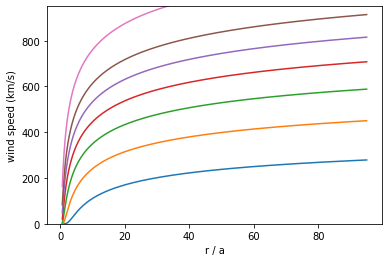

In [169]:
Tmax = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]) * 1.e6
nTmax = Tmax.size

nr = 90000
rxmax = (95.*1.e11)/6.96e10
mu = 0.5
psi = 4.2
delta = 0.0

rx_grid = np.zeros((nTmax,nr))
u_grid = np.zeros((nTmax,nr))
T_grid = np.zeros((nTmax,nr))
for i in range(0,nTmax,1):
    rxcrit,rx,T,u,ucrit = wind_radial_onefluid(nr,rxmax,mu,Tmax[i],psi,delta)
    rx_grid[i,:] = rx
    u_grid[i,:] = u
    T_grid[i,:] = T
#    print(rxcrit,ucrit/1.e5)

for i in range(0,nTmax,1):
    plt.plot(rx_grid[i,:]*6.96e10/1e11,u_grid[i,:]/1.e5)
plt.xlabel('r / a')
plt.ylabel('wind speed (km/s)')
plt.ylim(0,950)
plt.show();

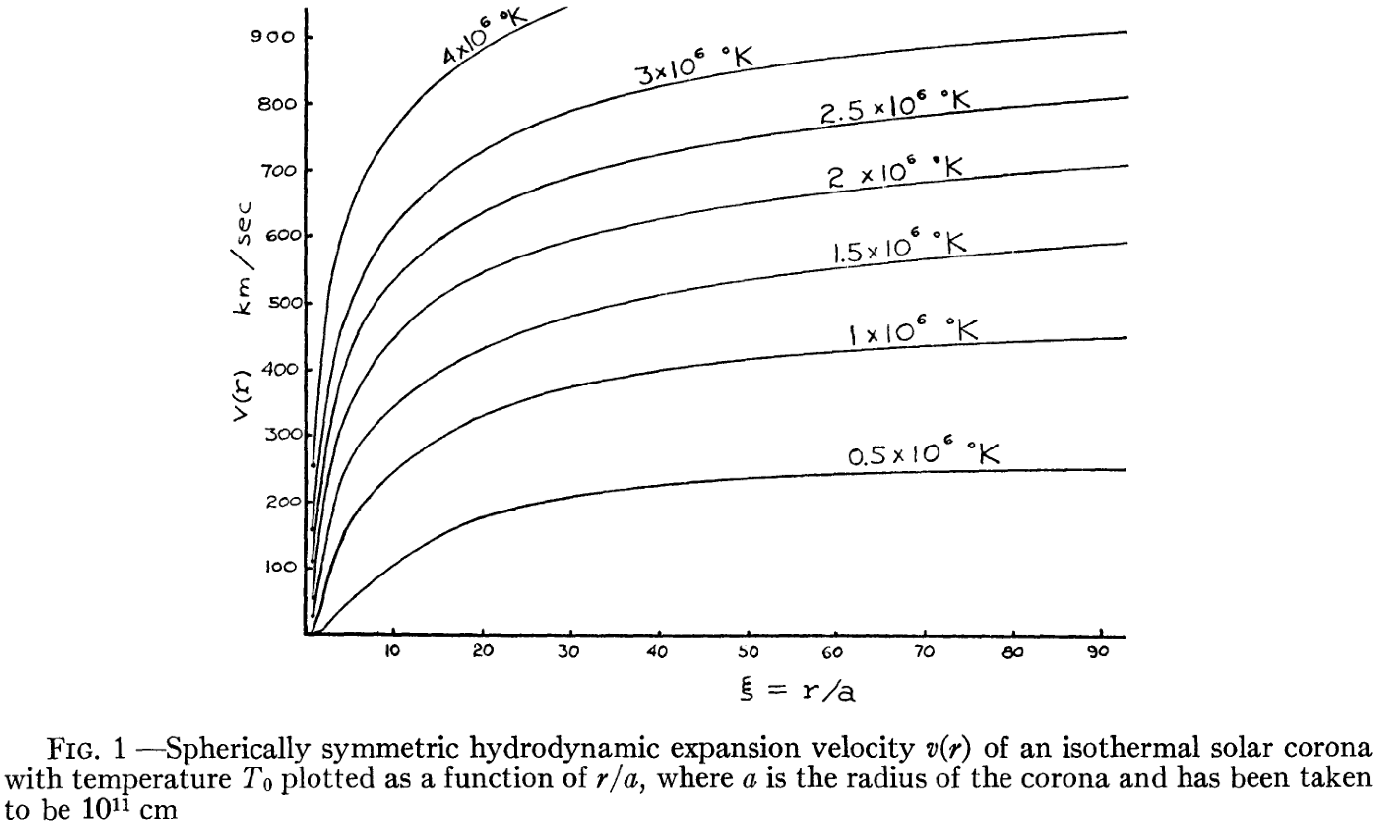

<font color=red><b>For you to try:</b></font>

First, note that my integration method was the simplest of the simplest methods... <b>1st order Euler steps.</b>  If you know of something more sophisticated that's already coded up nicely in python, maybe one could get away with fewer than 90,000 radial grid points!

(Of course, one must be careful with L'Hopital's rule around the critical point.  One other thing you can do is verify that my expression is correct.)

Second, there are all the other physical processes (bells and whistles) discussed in the lecture notes.

Third, if you choose the <i>negative</i> root of the L'Hopital slope at the critical point, you can integrate the spherical accretion solution worked out by <a href="https://ui.adsabs.harvard.edu/abs/1952MNRAS.112..195B/abstract">Bondi (1952)</a> (earlier than Parker!)
